# Projet NLP 
Anatole Gayant & Jules Avignon

sommaire :
Problématique : Quelles sont les tendances et les thèmes récurrents dans les paroles de chansons d'une décennie spécifique ?
Données : issue de kaggle https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset/
Traitements linguistiques : Lemmatisation, extraction de bi-grams/tri-grams, suppression des stop words.
Fouille : Topic modeling, détection de thèmes récurrents, comparaison avec d'autres décennies.

Description des données : 
Nous avons maintenant un dataframe combiné contenant 6027 chansons de différents artistes.

## 1 Préparation des données

In [1]:
import csv 
import os
import zipfile
import os
import pandas as pd
import re
import numpy as np

In [2]:
# Path to the uploaded archive
archive_path = "archive.zip"
extraction_path = "extracted_data/"

# Unzipping the archive
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Listing the extracted files
extracted_files = os.listdir(extraction_path)
# Listing the files inside the "csv" folder
csv_files_path = os.path.join(extraction_path, "csv")
csv_files = os.listdir(csv_files_path)

In [3]:
# Merging all the CSV files into a single dataframe

all_dataframes = []  # A list to store dataframes of each artist

# Looping through each CSV file and appending its content to the list
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(csv_files_path, csv_file))
    all_dataframes.append(df)

# Concatenating all dataframes
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Dropping the "Unnamed: 0" column
combined_df.drop(columns=["Unnamed: 0"], inplace=True)

# Displaying the first few rows after dropping the column
combined_df.head()

,Artist,Title,Album,Date,Lyric,Year
0,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,thought i'd end up with sean but he wasn't a m...,2018
1,Ariana Grande,7 rings,"thank u, next",2019-01-18,yeah breakfast at tiffany's and bottles of bub...,2019
2,Ariana Grande,​God is a woman,Sweetener,2018-07-13,you you love it how i move you you love it how...,2018
3,Ariana Grande,Side To Side,Dangerous Woman,2016-05-20,ariana grande nicki minaj i've been here all ...,2016
4,Ariana Grande,​​no tears left to cry,Sweetener,2018-04-20,right now i'm in a state of mind i wanna be in...,2018


## 1.2 Nettoyage des données

In [4]:
#quels sont les lignes de la colonne lyric qui ne sont pas des strings

# On crée une fonction qui va nous permettre de savoir si une valeur est un string ou non
def is_string(value):
    return isinstance(value, str)

# On applique la fonction à la colonne lyric
sum(combined_df["Lyric"].apply(is_string))

5981

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Téléchargement des ressources NLTK nécessaires
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

def clean_lyrics(lyrics):
    # S'assurer que les paroles sont une chaîne de caractères
    if not isinstance(lyrics, str):
        return ""
    # Suppression des caractères spéciaux
    lyrics = re.sub(r'[^A-Za-z0-9 ]+', '', lyrics)
    # Tokenization
    tokens = word_tokenize(lyrics)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    # Suppression des mots vides
    stop_words = set(stopwords.words('english'))
    cleaned_lyrics = [word for word in lemmatized if word not in stop_words]
    return ' '.join(cleaned_lyrics)

#utilisation de la fonction clean_lyrics pour nettoyer les paroles

combined_df['Lyric'] = combined_df['Lyric'].apply(clean_lyrics)
# pour appliquer la fonction calculate_genre_percentages à chaque ligne du dataframe il faut faire un sep entre les mots tokenisés
combined_df['Lyric'] = combined_df['Lyric'].apply(lambda x: x.split())

## 2 Classification des genres basées sur les paroles

Nous avons trouvé sur internet des mots associées a des styles musicaux :

Ces listes représentent des généralisations et peuvent ne pas refléter la diversité complète des paroles au sein de chaque genre. Les mots choisis tentent de capturer des thèmes fréquemment abordés ou des éléments stylistiques typiques de chaque genre.

In [6]:
#liste de genre musicaux et mots associés
genre_keywords = {
    "Rap": ["flow", "rhyme", "beat", "freestyle", "MC", "hood", "streets", "real", "life", "game", "bars", "verse", "rhymes", "spit", "rap", "flow", "mic", "lyric", "hip-hop", "graffiti", "beatbox", "cypher"],
    "R&B": ["love", "heart", "soul", "smooth", "passion", "feel", "emotion", "baby", "night", "dance", "rhythm", "blues", "groove", "melody", "sensual", "vocal", "smooth", "soulful", "harmony", "ballad", "serenade"],
    "Pop": ["fun", "party", "dance", "love", "night", "dream", "light", "young", "happy", "together","hit", "chart", "popstar", "melodic", "catchy", "hook", "radio", "mainstream", "singalong", "chorus", "verse"],
    "Rock": ["guitar", "band", "rock", "night", "live", "freedom", "rebel", "wild", "heart", "road", "electric", "solo", "drum", "bass", "loud", "amp", "punk", "metal", "grunge", "indie", "classic"],
    "Electro": ["beat", "dance", "night", "light", "energy", "bass", "synth", "club", "DJ", "party","techno", "house", "trance", "rave", "beat", "mix", "electronic", "DJ", "synthesizer", "drum machine", "dancefloor"]
}


def calculate_genre_percentages(tokenized_lyrics, genre_keywords):
    genre_counts = {genre: 0 for genre in genre_keywords}
    total_keywords_count = 0

    # Compter les occurrences des mots clés de chaque genre
    for word in tokenized_lyrics:
        for genre, keywords in genre_keywords.items():
            if word in keywords:
                genre_counts[genre] += 1
                total_keywords_count += 1
    # si a la fin de la boucle for total_keywords_count est égal à 0, total_keywords_count prend la valeur 1
    if total_keywords_count == 0:
        total_keywords_count = 1

    #affiche le nombre de mots de chaque liste de mots clés
    return {genre: count / total_keywords_count for genre, count in genre_counts.items()}


# appliquez la fonction calculate_genre_percentages à chaque ligne du dataframe
combined_df['genre_percentages'] = combined_df['Lyric'].apply(lambda x: calculate_genre_percentages(x, genre_keywords))

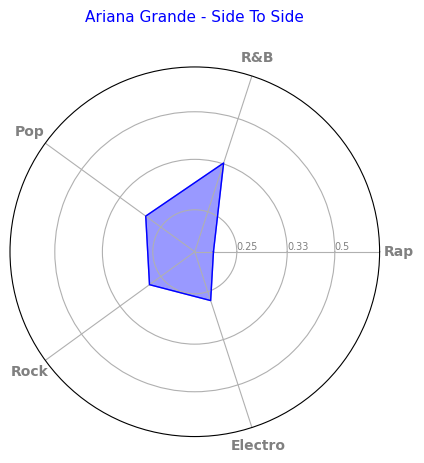

In [7]:
# fais un graphique de type radar qui montre la répartition des genres musicaux pour une chanson donnée

import matplotlib.pyplot as plt

# On crée une fonction qui va nous permettre de créer un graphique de type radar
def make_spider(row,artist ,title, color):
    # On crée un dataframe avec les données de la ligne
    df = pd.DataFrame({
        'group': list(row.keys()),
        'values': list(row.values())
    })
    # On crée un graphique de type radar
    categories = list(df['group'])
    N = len(categories)
    values = list(df['values'])
    values += values[:1]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks([0.15, 0.33, 0.5], ["0.25", "0.33", "0.5"], color="grey", size=7)
    plt.ylim(0, 0.66)
    ax.plot(angles, values, color=color, linewidth=1, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(f'{artist} - {title}', size=11, color=color, y=1.1)

# On fais le graphique pour la première ligne du dataframe
make_spider(combined_df['genre_percentages'][3], artist=combined_df['Artist'][3], title=combined_df['Title'][3], color='blue')

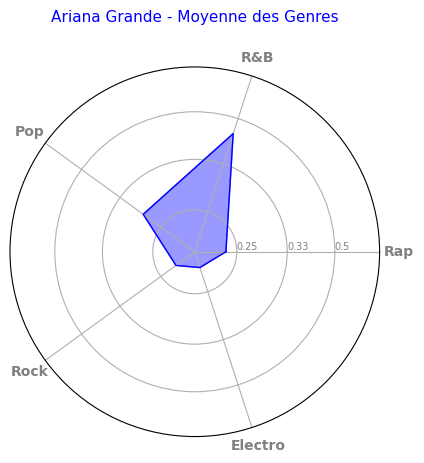

In [8]:
# crée une colonne pour chaque genre avec la valeur de la répartition du genre pour chaque chanson
for genre in genre_keywords:
    combined_df[genre] = combined_df['genre_percentages'].apply(lambda x: x[genre])

# Calculer la moyenne des pourcentages de genre pour un artiste spécifique
def calculate_average_genre_percentages(df, artist_name):
    artist_df = df[df['Artist'] == artist_name]
    mean_percentages = artist_df[['Rap', 'R&B', 'Pop', 'Rock', 'Electro']].mean()
    return mean_percentages.to_dict()

# Exemple d'utilisation
artist_name = "Ariana Grande"
average_percentages = calculate_average_genre_percentages(combined_df, artist_name)

# Créer le graphique radar pour l'artiste
make_spider(average_percentages, artist_name, "Moyenne des Genres", color='blue')



## Analyse des sentiments des paroles

In [9]:
mots_amour = ["love", "loved", "heart", "kiss", "romance", "passion", "desire", "embrace", "forever",
              "soulmate", "adore", "sweetheart", "cherish", "devotion", "affection", "tenderness",
              "enchant", "captivate", "infatuation", "yearning", "intimacy", "flame", "treasure",
              "amorous", "bliss", "allure", "eternity", "yearn", "romance", "heartbeat", "whisper",
              "serenade", "tender", "caress", "dream", "delight", "swoon", "cuddle", "darling",
              "beloved", "cupid", "harmony", "passionate", "spellbound", "admire", "infatuated",
              "butterfly", "wishes", "enrapture", "endear", "amour"]

mots_tristesse = ["sadness", "tear", "broken", "lonely", "sorrow", "grief", "heartbreak", "melancholy",
                  "despair", "pain", "regret", "anguish", "mourn", "misery", "wound", "dismay",
                  "desolation", "lament", "dejection", "disheartened", "downcast", "forlorn",
                  "woeful", "hopeless", "gloomy", "sullen", "bitter", "disappointed", "abandoned",
                  "betrayed", "crushed", "defeated", "wretched", "weary", "unhappy", "distraught",
                  "grief-stricken", "downhearted", "sombre", "unfulfilled", "melancholic", "aching",
                  "mourning", "brokenhearted", "troubled", "somber", "discouraged", "despondent",
                  "lonesome", "dolorous"]

mots_joie = [
    "joy", "joyful", "joyous", "delight", "delightful", "ecstasy", "ecstatic",
    "enjoy", "enjoyment", "enjoyable", "happiness", "happy", "cheer", "cheerful",
    "elation", "elated", "blissful", "glee", "gleeful", "content", "contentment",
    "satisfaction", "satisfied", "jubilation", "jubilant", "thrill", "thrilled",
    "exuberant", "exultant", "exhilaration", "mirth", "mirthful", "upbeat",
    "euphoria", "euphoric", "radiant", "beaming", "merry", "festive", "gratified",
    "gratifying", "jovial", "jolly", "buoyant", "lively", "spirited", "vibrant",
    "gleaming", "optimism", "optimistic", "rejoice", "rejoicing", "blessed",
    "sunshine", "bright"
]

mot_colere = ['anger', 'angry', 'rage', 'fury', 'furious', 'wrath', 'outrage',
            'indignation', 'resentment', 'irritation', 'irritated', 'annoyance',
            'annoyed', 'displeasure', 'displeased', 'irritate', 'infuriate', 'infuriated',
            'exasperation', 'exasperated', 'provocation', 'provoked', 'gall', 'irascibility',
            'irascible', 'outraged', 'indignant', 'resentful', 'irritating', 'annoying', 'displeasing',
            'infuriating', 'exasperating', 'provoking', 'galling', 'irritability', 'irritableness',
            'provocativeness', 'provokingness', 'gallingness', 'irritant', 'provocation', 'provoking', 
            'gall', 'irascibility', 'irascible', 'outraged', 'indignant', 'resentful', 'irritating', 
            'annoying', 'displeasing', 'infuriating', 'exasperating', 'provoking', 'galling', 'irritability',
            'irritableness', 'provocativeness', 'provokingness', 'gallingness', 'irritant'
]

# Fonction qui calcule le nombre de mots d'une liste dans une chanson
def calculate_number_of_words(lyrics, word_list):
    # On initialise le compteur de mots à 0
    word_count = 0
    # On parcourt les mots de la chanson
    for word in lyrics:
        # Si le mot est dans la liste, on incrémente le compteur de mots
        if word in word_list:
            word_count += 1
    return word_count



# On crée une fonction qui va nous permettre de calculer les pourcentages de mots de chaque liste pour chaque chanson
def calculate_percentage_of_emotions(df):
    nombre_mots_trouve = 1
    # On applique la fonction calculate_number_of_words à chaque ligne du dataframe pour chaque liste de mots on divise par le nombre total de mots trouvés sur les quatres listes de mots pour avoir un pourcentage
    nombre_mots_trouve = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_amour + mots_tristesse + mots_joie + mot_colere))
    df['pourcentage_amour'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_amour)) / nombre_mots_trouve
    df['pourcentage_tristesse'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_tristesse)) / nombre_mots_trouve
    df['pourcentage_joie'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_joie)) / nombre_mots_trouve
    df['pourcentage_colere'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mot_colere)) / nombre_mots_trouve
    return df

# appliquer la fonction à la première ligne du dataframe

combined_df = calculate_percentage_of_emotions(combined_df)

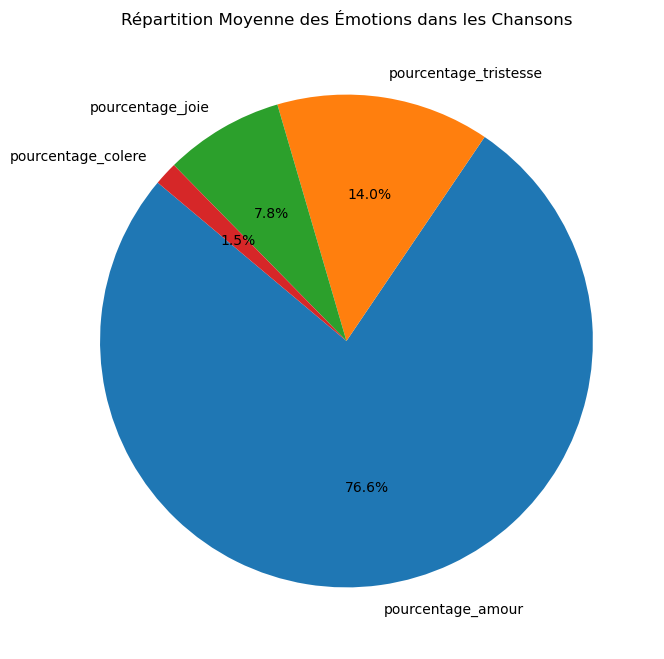

In [10]:
# Calculer les pourcentages moyens pour chaque émotion
average_percentages = combined_df[['pourcentage_amour', 'pourcentage_tristesse', 'pourcentage_joie', 'pourcentage_colere']].mean()

# Filtrer les émotions avec un pourcentage de 0
emotion_percentages = average_percentages[average_percentages > 0]

# Noms des émotions pour les labels du pie chart
emotion_labels = emotion_percentages.index

# Création du pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_percentages, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
plt.title('Répartition Moyenne des Émotions dans les Chansons')
plt.show()

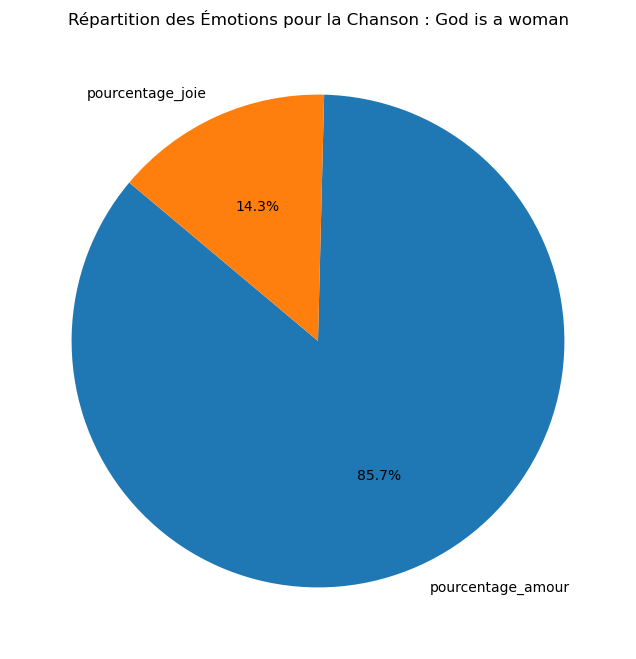

In [11]:
def plot_emotion_distribution(title, df):
    # Trouver la chanson par son titre
    song_data = df[df['Title'] == title]
    
    # Vérifier si la chanson existe
    if song_data.empty:
        print(f"Aucune chanson trouvée avec le titre : {title}")
        return

    # Sélectionner les pourcentages d'émotions pour la chanson
    emotion_data = song_data.iloc[0][['pourcentage_amour', 'pourcentage_tristesse', 'pourcentage_joie', 'pourcentage_colere']]
    
    # Filtrer pour exclure les émotions avec un pourcentage de 0
    emotion_data = emotion_data[emotion_data > 0]

    # Noms des émotions pour les labels du pie chart
    emotion_labels = emotion_data.index

    # Création du pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(emotion_data, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Répartition des Émotions pour la Chanson : {title}")
    plt.show()

# Exemple d'utilisation de la fonction
plot_emotion_distribution("​God is a woman", combined_df)

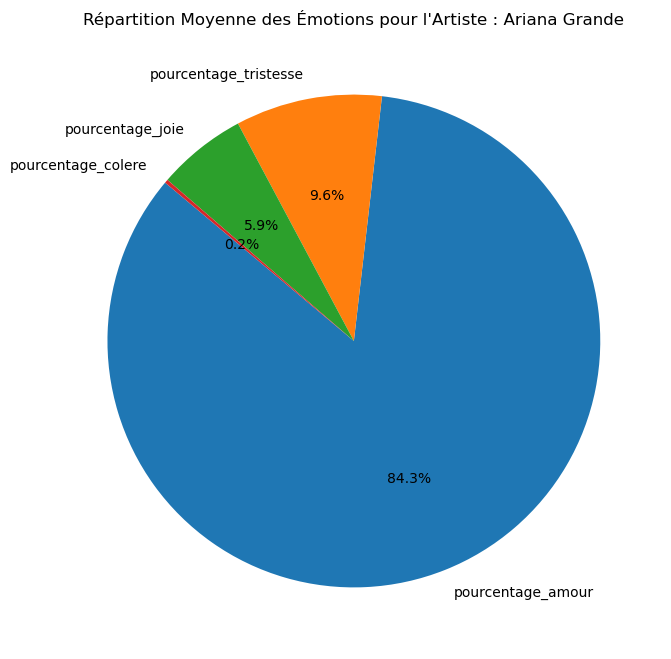

In [12]:
def plot_artist_emotion_distribution(artist_name, df):
    # Filtrer le DataFrame pour l'artiste donné
    artist_songs = df[df['Artist'] == artist_name]
    
    # Vérifier si des chansons de l'artiste existent
    if artist_songs.empty:
        print(f"Aucune chanson trouvée pour l'artiste : {artist_name}")
        return

    # Calculer la moyenne des pourcentages d'émotion pour toutes les chansons de l'artiste
    average_emotion_data = artist_songs[['pourcentage_amour', 'pourcentage_tristesse', 'pourcentage_joie', 'pourcentage_colere']].mean()
    
    # Filtrer pour exclure les émotions avec un pourcentage de 0
    average_emotion_data = average_emotion_data[average_emotion_data > 0]

    # Noms des émotions pour les labels du pie chart
    emotion_labels = average_emotion_data.index

    # Création du pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(average_emotion_data, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Répartition Moyenne des Émotions pour l'Artiste : {artist_name}")
    plt.show()

# Exemple d'utilisation de la fonction
plot_artist_emotion_distribution("Ariana Grande", combined_df)

# On veut faire une représentation de nos musiques par genre pour prendre les musique similaire a une autre. Faire de l'exploration de titre

In [13]:
import pandas as pd
from textblob import TextBlob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def sentiment_score(words):
    # Convertir la liste de mots en une chaîne de caractères
    lyric = ' '.join(words)
    return TextBlob(lyric).sentiment.polarity

# Appliquer la fonction à votre DataFrame
combined_df['sentiment_score'] = combined_df['Lyric'].apply(sentiment_score)

# Utiliser K-means pour le clustering
# Choisissez un nombre approprié de clusters
kmeans = KMeans(n_clusters=5)
combined_df['cluster'] = kmeans.fit_predict(combined_df[['sentiment_score']])


c:\Users\Administrateur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
import plotly.express as px
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Créer des vecteurs TF-IDF à partir des paroles
tfidf = TfidfVectorizer(max_features=100)  # Limiter le nombre de features pour simplifier l'exemple
tfidf_matrix = tfidf.fit_transform(combined_df['Lyric'].apply(lambda x: ' '.join(x)))

# Appliquer TruncatedSVD
svd = TruncatedSVD(n_components=2)
principal_components = svd.fit_transform(tfidf_matrix)
combined_df['feature_x'] = principal_components[:, 0]
combined_df['feature_y'] = principal_components[:, 1]


# Créer un graphique de dispersion avec Plotly
fig = go.Figure()

# Ajouter les points de chaque cluster
for cluster in combined_df['cluster'].unique():
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['feature_x'],
        y=cluster_data['feature_y'],
        mode='markers',
        marker=dict(size=10),
        name=f'Cluster {cluster}',
        hovertext=cluster_data['Artist'] + ' - ' + cluster_data['Title']
    ))

# Boutons pour choisir le cluster
cluster_buttons = []
for cluster in combined_df['cluster'].unique():
    cluster_buttons.append(
        dict(
            method='update',
            label=f'Cluster {cluster}',
            args=[{'visible': [cluster == c for c in combined_df['cluster'].unique()]}]
        )
    )

# Ajouter un bouton pour montrer tous les clusters
cluster_buttons.append(
    dict(
        method='update',
        label='Tous les clusters',
        args=[{'visible': [True for _ in combined_df['cluster'].unique()]}]
    )
)

# Mise à jour des layouts avec les boutons
fig.update_layout(
    title='Clusters de Chansons',
    xaxis_title='Caractéristique X',
    yaxis_title='Caractéristique Y',
    showlegend=True,
    updatemenus=[{"buttons": cluster_buttons, "direction": "down", "showactive": True}]
)

# Afficher le graphique
fig.show()



In [22]:
# afficher la chanson avec les paroles les plus proches d'une autre 

from sklearn.metrics.pairwise import cosine_similarity

def find_similar_songs(title, df):
    # Assurer que les paroles sont des chaînes de caractères
    df['Lyric'] = df['Lyric'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

    # Vérifier si la chanson existe
    if title not in df['Title'].values:
        print(f"Aucune chanson trouvée avec le titre : {title}")
        return

    # Vectoriser les paroles
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['Lyric'])

    # Récupérer l'index de la chanson sélectionnée
    song_index = df.index[df['Title'] == title].tolist()[0]

    # Calculer la similarité cosinus
    similarities = cosine_similarity(tfidf_matrix[song_index:song_index+1], tfidf_matrix)

    # Ajouter les similarités au DataFrame
    df['similarity'] = similarities[0]

    # Trier le DataFrame par similarité
    sorted_df = df.sort_values(by='similarity', ascending=False)

    # Afficher les 5 chansons les plus similaires sauf la chanson elle-même
    print(sorted_df[sorted_df['Title'] != title][['Artist', 'Title', 'similarity']].head(5))
# Exemple d'utilisation

print("Choisissez une chanson parmi la liste suivante :")
print(combined_df[['Artist', 'Title']].sample(10))
print("")
title = input("Entrez le titre de la chanson : ")
print("")
print("Chansons similaires :")
find_similar_songs(title, combined_df)


Choisissez une chanson parmi la liste suivante :
            Artist                           Title
5384  Selena Gomez                        Souvenir
1248  Charlie Puth             I Won’t Tell a Soul
2210      Dua Lipa                     Lot To Love
2315      Dua Lipa  Last Dance (Kriss Reeve Remix)
466        Beyoncé                  Yours And Mine
1863         Drake               Fire in the Booth
5058       Rihanna                     Photographs
1387      Coldplay                  Closer to Home
964    BTS (방탄소년단)    (Hidden Track) 길 (Road/Path)
1110   BTS (방탄소년단)  Make It Right (Acoustic Remix)


Chansons similaires :
             Artist                                Title  similarity
3615     Katy Perry                       Brick by Brick    0.202099
831   Billie Eilish             Bored{killer frostremix)    0.170559
4444       Maroon 5  Cold (Hot Shade & Mike Perry Remix)    0.170398
743   Billie Eilish                                Bored    0.167559
4414       Maroon 5  